# 4 ダイバーシチ合成(MRC + SC)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
path = "/content/drive/My Drive/Colab Notebooks"

## Pythonのバージョン確認と，必要なライブラリをインポートする．

In [ ]:
!python3 --version

import random

Python 3.7.14


In [ ]:
import matplotlib as makeMSL
import matplotlib.pyplot as plt
import numpy as np
import math

以下は$\mbox{erfc}$関数を読み込むためのライブラリ

In [ ]:
from scipy import special
from scipy.linalg import sqrtm

## 通信モデルに基づいたシミュレーション用のモジュール

*  情報源
*  情報源符号器
*  通信路符号器
*  通信路
*  白色ガウス雑音
*  通信路複復号器
*  情報源復号器

### 情報源
numpy.randomでも代用可

In [ ]:
'''
情報源クラス
'''
class InformationSource:
  def __init__(self,
                 N = 9,   #次数
                 a = 4, b = 9 #帰還タップ
                 ):
    self.N = N
    self.a = a
    self.b = b

  
  '''
  乱数(M系列)を発生させる
  @param informationSize int             発生させる乱数の個数
  @return information     numpy.ndarray 乱数
  '''
  def outputInformation(self, informationSize):
    information = np.empty(informationSize, dtype = int)

    for i in range(informationSize):
      if i < self.N :
        information[i] = random.randrange(2)
      else :
        information[i] = information[i - self.a] ^ information[i - self.b]

    return information

### 情報源符号器

In [ ]:
'''
情報源符号器
'''
class Encoder:
  '''
  @param M int 符号のビット数
  '''
  def __init__(self,
               M #符号のビット数
               ) :
    self.M = M

    #２進数のマスク
    self.mask = np.array([1 << bit for bit in range(M)])
  
  '''
  0/1乱数をM[bit]の符号にする
  @param information numpy.ndarray 0/1の乱数(情報)
  @return data        numpy.ndarray 符号
  '''
  def encode(self,
             information):
    information2 = np.concatenate([information, information])

    data = np.array([
        self.mask @ information2[i: i + self.M] 
        for i in range(information.size)
    ])
    data = np.reshape(data, (1, data.size))

    return data

    return np.array([
        np.array([self.mask @ information2[i: i + self.M] ])
        for i in range(information.size)
    ])
    
    '''
    return np.array([
        self.mask @ information2[i: i + self.M]
        for i in range(information.size)
    ])
    '''

### 通信路符号器

Mは単位が[bit]とする
**MPSKのとき**$$\mathbb{Z} \mapsto \mathbb{C}:x\mapsto \sqrt{P_s} \cdot  \exp\Big(j\frac{2\pi}{2^M}x\Big)$$  <br>

**MQAMのとき**<br>データ$x$を上位ビット$x^U$，下位ビット$x^L$に分けて
$$
f:\times2d - (2^{M/2} - 1)d
$$
を作用させてそれぞれ複素信号$s$の実部$s^I$と虚部$s^Q$とする． <br>
ただし$2d$は信号点間隔であり，電力$\mathbb{E}\big[|s|^2\big]$を$P_S$に固定するとき
$$
P_S = 
\frac{1}{2^M} \cdot
\sum_{x \in \{0, 1, \cdots 2^M - 1\} }
  \Bigg\| f(x^U) + jf(x^L) \Bigg\|^2
$$

より$d$は以下のように確定する.

$$
d = \sqrt{\frac{3}{2} \frac{P_S}{2^M - 1 } }
$$

In [ ]:
'''
通信路符号器
'''
class Modulator:
  '''
  constructor
  @param M              int   多値数[bit] 単位がビットであることに注意
  @param mode          str   変調方式 ex) mode = "PSK", mode = "QAM"
  @param isGrayCode    bool  グレイコードにするか否か
  @param powerOfSignal float １シンボルあたりの送信電力 (１ビットあたりの送信電力ではない！)
  '''
  def __init__(self,
               M,
               mode,
               isGrayCode = True,
               powerOfSignal  = 1.0
               ):
    
    self.M = M
    self.mode = mode
    self.isGrayCode = isGrayCode
    self.powerOfSignal = powerOfSignal

    if mode == "QAM":
      self.d = math.sqrt(
          1.5 * self.powerOfSignal / ( (1 << self.M) - 1 )
      )
    
    elif mode == "PSK":
      self.A  = math.sqrt( self.powerOfSignal )

  '''
  変調
  @param data     np.ndarray データ
  @return symbol  np.ndarray シンボル
  '''
  def modulate(self,data):
    if self.mode == "PSK":
      if self.isGrayCode == True:
        data = self.grayEncode(data)
      return self.A * np.exp(1j * 2.0 * np.pi/ (1 << self.M) * data)
    
    if self.mode == "QAM":
      x_U = self.sliceUpperBit(data)
      if self.isGrayCode == True:
        x_U = self.grayEncode(x_U)

      x_L = self.sliceLowerBit(data)
      if self.isGrayCode  == True:
        x_L = self.grayEncode(x_L)

      s_I = self.f(x_U)
      s_Q = self.f(x_L)
      return s_I + 1j * s_Q
  
  '''
  上位ビット取得
  @param x    np.ndarray {0, 1, ..., 2^M - 1} データ
  @return x_U np.ndarray 上位ビット
  '''
  def sliceUpperBit(self, x) :
    return (
        x >> (self.M//2)
    )
  
  '''
  下位ビット取得
  @param x    np.ndarray {0, 1, ..., 2^M - 1} データ
  @return x_D np.ndarray 下位ビット
  '''
  def sliceLowerBit(self, x) :
    return x & (
        ( 1 << (self.M//2) ) - 1
    )
  
  '''
  M/2ビットを等間隔に配置
  @param x_           np.ndarray  M/2ビットのデータ
  @return symbolPart   np.ndarray  信号点のI/Q座標
  '''
  def f(self, x_):
    return self.d * (
          x_ * 2 - (
              (1 << (self.M//2) ) - 1
            )
        )
  
  '''
  グレイコードにする
  @param n            array_like integer
  @return              array_like gray coded object
  '''
  def grayEncode(self, n):
    return n ^ n >> 1
  
  '''
  グレイコードから直す
  @param n           array_like gray coded object
  @return             array_like gray decoded object
  '''
  def grayDecode(self, n):
    i = isinstance(n, int)
    n = np.array([n]) if i else n.copy()
    m = n >> 1
    while not (m == 0).all():
        n ^= m
        m >>= 1
    return n[0] if i else n
  
  '''
  信号点配置の表示と電力を計算する
  '''
  def debug(self):
    dataSet = np.arange(1 << self.M)
    dataset = self.grayEncode(dataSet)
    symbolSet = self.modulate(dataSet)

    plt.scatter( symbolSet.real, symbolSet.imag, label = "{}{}".format(1 << self.M, self.mode))
    for n in range(1 << self.M):
      data = dataSet[n]
      symbol = symbolSet[n]
      plt.annotate("${}$".format( format(data, 'b') ), xy = (symbol.real, symbol.imag))

    plt.xlabel("I")
    plt.ylabel("Q")


    plt.legend()
    plt.savefig("{}{}.png".format(
        1 << self.M,
        self.mode  
      )
    )

    plt.show()

    print("calculated power of signal: {}".format(
        math.sqrt(
          np.mean( np.abs(symbolSet) ** 2 )
        )
      )
    )

### 空間多重装置

ストリームを多重化する．最も単純なのは
$$
x \mapsto 
\begin{bmatrix}
x \\
x
\end{bmatrix}
$$

In [ ]:
'''
空間(逆)多重装置 抽象化クラス
@param Nt         int          送信アンテナ数
@param Nr         int          受信アンテナ数
@param H          np.ndarray  チャネル行列
'''
class MUX_:
  def __init__(self, Nt, Nr, H):
    self.Nt = Nt
    self.Nr = Nr
    self.H = H



In [ ]:
'''
空間多重装置
@param Nt         int          送信アンテナ数
@param Nr         int          受信アンテナ数
@param H          np.ndarray  チャネル行列
@param MUXmode  str         多重方式  ex)"E-SDM", "" ただし ""←はx -> [x x ... x]^Tにすることを指す
'''

class MUX(MUX_):
  def __init__(self, Nt, Nr, H, MUXmode = ""):
    super().__init__(Nt, Nr, H)
    self.MUXmode = MUXmode
    self.weight = self.calcWeight()
  
  def calcWeight(self):
    if self.MUXmode == "":
      weight = np.ones((1, self.Nt))
      return weight
  
  '''
  ストリームxをW^H xに空間多重する
  
  @param streamInput   np.ndarray (1, * ) 空間多重されるストリーム
  @return streamOutput np.ndarray         空間多重したストリーム
  '''
  def multiplex(self, streamInput):
    streamOutput = np.conjugate(self.weight).T @ streamInput
    return streamOutput

### 通信路

In [ ]:
'''
通信路
'''
class Channel:
  '''
  @param channelMatrix np.ndarray チャネル行列H
  '''
  def __init__(self, channelMatrix):
    self.channelMatrix = channelMatrix
  
  '''
  シンボルsを通信路Hに通して出力( y = Hu 出力)
  @param symbol np.ndarray 入力シンボル
  @reutrn         np.ndarray 出力シンボル
  '''
  def transport(self, symbol):
    return self.channelMatrix @ symbol

In [ ]:
'''
クロネッカーモデル通信路
'''
class KroneckerChannel(Channel):
  '''
  @paran Nt   送信アンテナ数
  @paran Nr   受信アンテナ数
  @param rho 相関係数
  @param
  '''
  def __init__(self, Nt, Nr, rho):
    self.Nt = Nt
    self.Nr = Nr
    self.rho = rho
    
    self.Rt = self.Nt * self.exponentialCorrelationMatrix(self.Nt, self.rho)
    self.G = self.gaussianMatrix(self.Nr, self.Nt)
    self.Rr = self.Nr * self.exponentialCorrelationMatrix(self.Nr, self.rho)
    self.kappa = np.trace(self.Rt)


    self.H = self.calcKroneckerChannel(self.Rt, self.G, self.Rr, self.kappa)

    super().__init__(channelMatrix = self.H)
  
  def exponentialCorrelationMatrix(self, N, rho):
    mat = np.array([
        [ i - j for j in range(N) ]
        for i in range(N)
    ])
    mat = np.abs(mat)
    mat = np.power(rho, mat)
    return mat
  
  def gaussianMatrix(self, rowNum, colNum):
    mat = np.array([
        [
            random.gauss(mu = 0, sigma = np.sqrt(0.5) ) + 1j * random.gauss(mu = 0, sigma = np.sqrt(0.5) ) 
            for col in range(colNum)
        ]
        for row in range(rowNum)
    ])
    return mat
  
  '''
  H = Rr^{1/2} G ( Rr^{1/2} )^H / \sqrt{\kappa}
  '''
  def calcKroneckerChannel(self, Rt, G, Rr, kappa):
    return sqrtm(Rr) @ G @ (sqrtm(Rt)).conj().T / np.sqrt(kappa)

  def debug(self):
    print("start debug")
    #print( self.exponentialCorrelationMatrix(3, 0) )
    
    Rt = np.zeros( (self.Nt, self.Nt) )
    
    N = 1000
    for n in range(N):
      G = self.gaussianMatrix(self.Nr, self.Nt)
      H = self.calcKroneckerChannel(self.Rt, G, self.Rr, self.kappa)

      Rt_ = H.conj().T @ H

      Rt = Rt + Rt_
    
    Rt /= N
    print("Rt/Nr{}".format( Rt/self.Nr ))


    print("end debug")

### 白色ガウス雑音加算器
複素ガウス分布に従う雑音$\boldsymbol{n}$をBox-Muller法で発生させる．
$$
\boldsymbol{n} \sim \mathcal{CN}( 0, \sigma^2  )
$$
実部と虚部は$\mathcal{N}(0, \sigma^2/2)$に従うことに注意

In [ ]:
class AwgnAdder:
  '''
  constructor
  '''
  def __init__(self):
    return
  
  '''
  シンボルにガウスノイズn ~ CN(0, σ^2)をのせて返す
  @param symbol  np.ndarray       シンボル
  @param variance float            分散
  @return symbolNoized np.ndarray ノイズが加算されたシンボル
  '''
  def addAwgn(self, symbol, variance):
    noizeVector = np.array([
          self.generateGaussian(variance) for _ in range(symbol.size)
        ])
    noizeMatrix = noizeVector.reshape( symbol.shape )
    return symbol + noizeMatrix

  ''''
  複素標準ガウス雑音n ~ CN(0, σ^2)生成
  @param variance float     分散σ^2
  @return gaussian complex 複素標準ガウス雑音n ~ CN(0, σ^2)
  '''
  def generateGaussian(self, variance):
    #確率変数x_1, x_2 ~ U(0, 1)
    x_1 = random.uniform(0.0, 1.0)
    x_2 = random.uniform(0.0, 1.0)

    #確率変数x_1, x_2を変換して標準正規分布に従う確率変数y_1, y_2とする
    y_1 = np.sqrt(-2.0 * np.log(x_1)) * np.cos(2.0 * np.pi * x_2)
    y_2 = np.sqrt(-2.0 * np.log(x_1)) * np.sin(2.0 * np.pi * x_2)

    return np.sqrt( variance / 2.0) * (y_1 + 1j * y_2)

### 通信路逆多重装置
主にダイバーシチ合成のため．

#### 選択合成ダイバーシチ
各アンテナブランチから最も$SNR$が良好($=$電力が最大)なアンテナを選択して受信する方法. <br>
受信側で受けとった信号
$$
y = \begin{bmatrix}h_1 \\ h_2 \\ \vdots \\ h_{Nr}\end{bmatrix}x + n
$$
に対して
次のウェイト$w$を$w^H y$のかたちで積をとる．
$$
w = \begin{bmatrix} 0 \\ \vdots \\  \frac{h_t}{|h_t|^2} \\ \vdots \\  0 \end{bmatrix} \\
t = (\mbox{ウェイトベクトルで一番大きい要素のインデックス}) = \arg \max _t |h_t|
$$

#### 最大比合成ダイバーシチ
各アンテナの受信信号の位相を調節して$SNR$が最大になるようにする方法 <br>
受信側で受け取った信号
$$
y = \begin{bmatrix}h_1 & h_2 & \cdots & h_{Nt}\end{bmatrix}x + n
$$
に対して次のウェイト行列$W = \begin{bmatrix} w_1 & \cdots & w_t & \cdots & h_{Nt}\end{bmatrix}$を$W^H y$のかたちで積をとる．

$$
w_t = h_t
$$
もしくは大きさを正規化しておく．つまり基本的にウェイト行列$W$は
$$
W = H
$$
である．

In [ ]:
'''
空間逆多重装置
@param Nt            int          送信アンテナ数
@param Nr            int          受信アンテナ数
@param H             np.ndarray  チャネル行列
@param DEMUXmode  str          多重方式  ex) "SC", "MRC", "MMSE"
'''
class DEMUX(MUX_):
  def __init__(self, Nt, Nr, H, DEMUXmode):
    super().__init__(Nt, Nr, H)
    self.DEMUXmode = DEMUXmode
    self.weight = self.calcWeight()

  def calcWeight(self):
    if self.DEMUXmode == "SC":
      weight = np.zeros((self.Nr, 1), dtype = "complex_")
      t = np.argmax( np.abs(self.H) )
      weight[t] = self.H[t][0] / ( np.abs(H[t][0]) ** 2 )
      return weight
    
    elif self.DEMUXmode == "MRC":
      weight = self.H
      '''
      HSquared = np.square(self.H)
      normSquared = np.sum( HSquared )
      norm = np.sqrt(normSquared)
      '''
      norm = np.linalg.norm(self.H, ord = 2)
      return weight / norm

  
  '''
  ストリームxをW^H xにする
  
  @param streamInput   np.ndarray (1, * ) ウェイトをかけられる対象のストリーム
  @return streamOutput np.ndarray         ウェイトをかけられたストリーム
  '''
  def demultiplex(self, streamInput):
    streamOutput = np.conjugate(self.weight).T @ streamInput
    return streamOutput

### 通信路複復号器

***MPSK M$[\rm{bit}]$*** のとき <br>
受け取った信号$y$に対して
$$
\hat{x} = \rm{round} \Bigg( 
  \frac{
  \rm{arg}(y)
}{
  2 \pi / 2^M
} \Bigg)
$$
と復調する．<br>

***MQAM M$[\rm{bit}]$***のとき <br>
受け取った信号$y = y^I + j y^Q$に対して
$$
\hat{x}^{(\cdot)}  = \rm{round}\Bigg(
  \frac{1}{2}
  \bigg\{
    \frac{y^{(\cdot)} }{d} + 2^{M/2} - 1
  \bigg\}
  \Bigg)
$$
として上位ビット$\hat{x}^U$および下位ビット$\hat{x}^D$と復調する. <br>
ただし$\hat{x}^{(\cdot)} < 0$のとき$\hat{x}^{(\cdot)} = 0$, $\hat{x}^{(\cdot)} \geq 2^{M/2}$のとき$\hat{x}^{(\cdot)} = 2^{M/2} - 1$とする．<br>

また，計算量はあるが確実な方法として最小ノルムを指定するシンボルを推定地にする復調法も実装した．すなわち
$$
\hat{x} = \rm{arg min}_{x \in \{0, 1, \cdots, 2^M-1\} } \Big\| \rm{modulate} (x) - y \Big\|
$$

In [ ]:
class Demodulator(Modulator):
  '''
  constructor
  @param M              int   多値数[bit] 単位がビットであることに注意
  @param mode          str   変調方式 ex) mode = "PSK", mode = "QAM"
  @param argmin         bool argminで復調するか否か
  @param powerOfSignal float １シンボルあたりの送信電力 (１ビットあたりの送信電力ではない！)
  '''
  def __init__(self,
               M,
               mode,
               isGrayCode = True,
               powerOfSignal  = 1.0,
               argmin = False
               ):
    super().__init__(M, mode, isGrayCode, powerOfSignal)
    self.argmin = argmin
    self.dataOrigin = np.arange(1 << self.M)
    if self.isGrayCode == True:
      self.dataOrigin =  self.grayEncode( self.dataOrigin )
    self.symbolOrigin = self.modulate(self.dataOrigin)
    
    

  '''
  復調
  @param symbolReceived         np.ndarray 受け取ったシンボル
  @return dataDemodulated       np.ndarray 復調されたデータ
  '''
  def demodulate(self, symbolReceived):
    if self.argmin == True:
      dataDemodulated =  np.array([
          np.argmin(
              abs(self.symbolOrigin - symbolReceived_) 
          )
          for symbolReceived_ in symbolReceived
      ])

      if self.isGrayCode == True:
        dataDemodulated = self.grayDecode( dataDemodulated )

    elif self.mode == "PSK":
      dataDemodulated = np.angle( symbolReceived )
      dataDemodulated = dataDemodulated / (
          2.0 * np.pi / ( 1 << self.M )
      )
      dataDemodulated = dataDemodulated.round()
      dataDemodulated = np.array(dataDemodulated.round(), dtype = 'int')
      dataDemodulated = np.where(dataDemodulated < 0,
                                   dataDemodulated + (1 << self.M),
                                   dataDemodulated)
      if self.isGrayCode == True:
        dataDemodulated = self.grayDecode( dataDemodulated )
    
    elif self.mode == "QAM":
      x_U = symbolReceived.real / self.d + (1 << self.M//2) - 1
      x_U /= 2.0
      x_U = x_U.round()
      x_U = np.array(x_U, dtype = 'int')
      x_U = np.where(x_U < 0, 0, x_U)
      x_U = np.where(x_U > ( (1 << self.M//2) - 1), (1 << self.M//2) - 1, x_U)

      x_L = symbolReceived.imag / self.d + (1 << self.M//2) - 1
      x_L /= 2.0
      x_L = x_L.round()
      x_L = np.array(x_L, dtype = 'int')
      x_L = np.where(x_L < 0, 0, x_L)
      x_L = np.where(x_L > ( (1 << self.M//2) - 1), (1 << self.M//2) - 1, x_L)

      if self.isGrayCode == True:
        x_U = self.grayDecode(x_U)
        x_L = self.grayDecode(x_L)
      
      dataDemodulated = (x_U << self.M//2) + x_L
    
    return dataDemodulated
  
  '''
  信号点配置の表示と電力を計算する
  '''
  def debug(self):
    dataSet = np.arange(1 << self.M)
    symbolSet = self.modulate(dataSet)

    dataDemodulated = self.demodulate( symbolSet )
    print("data origin: {}".format(dataSet))
    print("data demodulated {}: ".format(dataDemodulated) )

## その他のモジュール

### $\rm{SNR}$もしくは$\frac{E_b}{N_0}$から雑音$\boldsymbol{n} $の分散$\sigma^2$を計算する関数

**SN比から雑音の分散を計算**<br>繰り返し記述しておくが，雑音$ \boldsymbol{n}$の実部，虚部はそれぞれ$\mathcal{N} (0, \sigma^2/2)$に従う.
$$
\rm{SNR} [\mbox{dB}]  = 10 \log_{10} \frac{P_S}{P_N} = 10 \log_{10} \frac{1}{  \sigma^2 }
$$

$$
\therefore
\rm{分散} \sigma^2 = 10^{- \rm{SNR}/10 }
$$

**$\frac{ E_b }{ N_0 }$から雑音の分散を計算**<br>


$$
\begin{cases}
P_S &= M[\rm{bit}] \times E_b \\
\frac{E_b}{N_0} &= 10 \log_{10} \Big( \frac{ E_b }{ \sigma^2 } \Big) 
\end{cases}
$$


$$
\therefore \mbox{分散} \sigma^2 = \frac{P_S}{ M[\rm{bit}] } 10^{
 - E_b/N_0 \big/ 10
}
$$

In [ ]:
'''
雑音分散を計算
@param rate          float     SNR or EbN0
@param rateMode    str      "SNR" or "EbN0"
@param M            int      多値数[bit]
@param P_S          float    信号電力
@return variance      float    雑音の分散
'''
def calcVariance(
    rate,
    rateMode,
    M,
    P_S = 1.0
):
  if rateMode == "SNR" :
    return np.power(10.0, - rate / 10.0 )
  
  elif rateMode == "EbN0":
    return P_S / M * np.power(10.0, - rate / 10.0)

### SER/BER計算機
送信したデータセットと，復調したデータセットの中身のうち正しく予測したものの割合

In [ ]:
'''
SER/BER計算機
@param M              int 多値数[bit]
@param errrorMode     str "SER" or "BER"
'''
class ErrorCalculator:
  def __init__(self, M, errorMode) :
    self.M = M
    self.errorMode = errorMode

  
  '''
  SER or BER計算
  @param dataOrigin        変調する前のデータ
  @param dataDemodulated 復調したデータ
  '''
  def calcError(self,
                dataOrigin,
                dataDemodulated):
    if self.errorMode == "SER":
      return self.calcSER(dataOrigin, dataDemodulated)
    
    elif self.errorMode == "BER":
      return self.calcBER(dataOrigin, dataDemodulated)

  '''
  SER計算
  @param dataOrigin        変調する前のデータ
  @param dataDemodulated 復調したデータ
  '''
  def calcSER(self, 
              dataOrigin,
              dataDemodulated):
    return np.count_nonzero(
        dataOrigin != dataDemodulated
    ) / dataOrigin.size

  '''
  BER計算
  @param dataOrigin        変調する前のデータ
  @param dataDemodulated 復調したデータ
  '''
  def calcBER(self,
              dataOrigin,
              dataDemodulated):
    dataDelta = dataOrigin ^ dataDemodulated
    dataDeltaBits = np.array([
        self.transformBitsFromInt(data)
        for data in dataDelta
        ])
    '''
    or
    dataDeltaBits = self.transformBitsFromInt(data)
    '''

    deltaCnt = np.sum( dataDeltaBits )

    return deltaCnt / dataDeltaBits.size

  '''
  整数を{0,1}^(桁数)に変換
  @param integer          int        変換する整数
  @return bits             np.ndarray 変換された0/1ビット配列
  '''
  def transformBitsFromInt(self, integer):
    return np.array([
        ( integer & (1 << m) ) >> m
        for m in range( self.M )
    ])


### SER, BERの理論式

$M$[bit]個のビット列からなるシンボル誤り率$P_{\rm{SER}}$は，ビット誤り率$P_{\rm{BER}}$と
$$
P_\rm{BER} = \frac{2^{M-1}}{2^M - 1} P_\rm{SER}
$$
という関係がある．<br>

**PSK**の理論式
$M = 1$(BPSK)のとき
$$
P_\rm{SER} = \frac{1}{2} \rm{erfc}( \sqrt{\gamma} )
$$

それ以外
$$
P_\rm{SER} \simeq \rm{erfc} \Bigg(\sqrt{\gamma} \sin \frac{\pi}{2^M}\Bigg)
$$

**QAM**の理論式

$$
P_\rm{SER} \simeq 2\Big(1 - \frac{1}{ 2^{M/2} } \Big) \rm{erfc}
\Bigg[ 
\sqrt{ \frac{3}{2(2^M - 1)} \cdot \gamma}
\Bigg]
$$
ただし$\gamma_p$は最大振幅を持つ信号の電力対雑音電力比

あるいは
$$
P_{BER} = P_{SER} if PSK \\
P_{BER} = \alpha \ \rm{erfc}\Big( \sqrt{
  \frac{\gamma}{\beta}
}  \Big)
$$

| | | |
| --- | --- | --- |
|  | $\alpha$ | $\beta$ |
| QPSK | 1/2 | 2 |
| 16QAM | 3/8 | 10 |
| 64QAM | 7/24 | 42 |
| 256QAM | 15/64 | 42 | 
| 1024QAM | 31/160 | 682 |


In [ ]:
'''
SNR or Eb/N0によるSER or BERの理論式
@param M            int     多値数[bit]
@param mode        str    "PSK" or "QAM"
@param gammaMode str    "EbN0" or "SNR"
@param gamma      float   SN比
@param errorMode   str    "SER" or "BER"

@return P_e       float 誤り率(P_SER or P_BER)
'''
def errorTheoreticalValue(
    M,
    mode,
    gammaMode,
    gamma,
    errorMode
) :
  if gammaMode == "EbN0":
    gamma *= M
  


  if mode == "PSK":
    P_SER = special.erfc(
        np.sqrt(gamma) * np.sin( np.pi / (1 << M) )
    )
    if M == 1:
      P_SER /= 2
  

  elif mode == "QAM":
    P_SER = 2.0 * (1.0 - 1.0/(1<< M//2) ) * special.erfc( np.sqrt(
          3.0 / (2.0 * ( (1 << M) - 1) ) * gamma
        )
      )



  if errorMode == "SER":
    return P_SER
 

  elif errorMode == "BER":
    if mode == "QAM":
      if M > 10:
        P_BER = P_SER / M
        #P_BER = (1 << (M  - 1)) / ( (1 << M) - 1) * P_SER
      else:  
        if M == 4: #16QAM
          alpha, beta = 3/8, 10
        elif M == 6: #64QAM
          alpha, beta = 7/24, 42
        elif M == 8: #256QAM
          alpha, beta = 15/64, 170
        elif M == 10: #1024QAM
          alpha, beta = 31/160, 682
        P_BER = alpha * special.erfc( np.sqrt( gamma / beta ) )
      
    else: #PSK
      P_BER = P_SER / M
      #P_BER = (1 << (M  - 1)) / ( (1 << M) - 1) * P_SER
 
    return P_BER

## Simulation of MRC, SC

### SC

####  $Nt = 1, Nr = 2$

パラメータ

|    |    |
| ---- | ---- |
| 送信アンテナ数 | 1 |
| 受信アンテナ数 | 2 |
| 変調方式 | QPSK |
| チャネル　|　レイリーフェージング|
|  試行回数  |  10万回  |
|  $E_b/N_0$  |  0[dB]~30[dB]  |
| 送信電力 | 1 |
|ダイバーシチ|選択合成|

In [ ]:
#誤り基準
errorMode = "BER"

#変調方式
mode = "PSK"

#多値数
M = 2

#試行回数
informationSize = 100000

#EbN0
rateMode = "EbN0"
EbN0_MIN = 0
EbN0_MAX = 30

#定義域(SNR)
N = (EbN0_MAX - EbN0_MIN) + 1
EbN0 = np.linspace(EbN0_MIN, EbN0_MAX, N)

#送信電力
powerOfSignal = 1.0

#送信/受信アンテナ数
Nt, Nr = 1, 2

#ダイバーシチ
MUXmode = ""
DEMUXmode = "SC"

In [ ]:
modulator = Modulator(M = M, mode = mode, powerOfSignal = powerOfSignal)

awgnAdder = AwgnAdder()

demodulator = Demodulator(M = M, mode = mode, powerOfSignal = powerOfSignal)

errorCalculator = ErrorCalculator(M = M, errorMode = errorMode)

In [ ]:
#データを変調
dataOrigin = np.random.randint(low = 0, high = 1 << M, size = [1, informationSize])
symbol = modulator.modulate(dataOrigin)

##### 実行

In [ ]:
BER_EbN0_QPSK = np.zeros(shape = EbN0.shape)

for n in range(N):
  dataDemodulated = np.empty( symbol.shape, dtype = int )
  for i in range(informationSize):
    #進捗確認バー
    if (i * 10) % informationSize == 0:
      print('#' * ( (i * 10) // informationSize ) )

    #シンボルsを通信路Hに通しノイズnをのせる
    channel = KroneckerChannel(Nt = Nt, Nr = Nr, rho = 0)

    symbol_i = np.array([[ symbol[0][i] ]])
    symbolTransported = channel.transport( symbol_i )

    symbolNoized = awgnAdder.addAwgn(
                                      symbolTransported, 
                                      calcVariance(
                                          rate = EbN0[n], rateMode = rateMode,
                                          M = M, P_S = powerOfSignal)
                                    )
    
    #ウェイトをDEMUXでかけて，復調
    demux = DEMUX(Nt = Nt, Nr = Nr, H = channel.channelMatrix, DEMUXmode = DEMUXmode)
    symbolDemultiplexed = demux.demultiplex(symbolNoized)

    dataDemodulated_ = demodulator.demodulate(symbolDemultiplexed)
    dataDemodulated[0][i] = dataDemodulated_

  #元のデータと復調データを照らし合わせてBER計算
  ber = errorCalculator.calcError(dataOrigin, dataDemodulated)

  '''debug start'''
  '''
  print("dataOrigin {}".format(dataOrigin))
  print("symbol {}".format(symbol))
  print("H {}".format(channel.channelMatrix) )
  print("symbolNoized {}".format(symbolNoized) )
  print("symbolDemultiplexed ".format(symbolDemultiplexed))
  print("dataDemodulated {}".format( dataDemodulated) )
  '''
  '''debug end'''

  print("EbN0: {} BER: {}".format( EbN0[n], ber) )
  BER_EbN0_QPSK[n] = ber

#BER_EbN0_QPSK_1_4_SC
np.savetxt(
    path + "/{}_{}_{}{}_{}_{}_{}.csv".format(
        errorMode,
        rateMode,
        M,
        mode,
        Nt,
        Nr,
        DEMUXmode
    ), 
    np.stack([
      EbN0,
      BER_EbN0_QPSK
]))


#
##
###
####
#####
######
#######
########
#########
EbN0: 0.0 BER: 0.038145

#
##
###
####
#####
######
#######
########
#########
EbN0: 1.0 BER: 0.02725

#
##
###
####
#####
######
#######
########
#########
EbN0: 2.0 BER: 0.020355

#
##
###
####
#####
######
#######
########
#########
EbN0: 3.0 BER: 0.01411

#
##
###
####
#####
######
#######
########
#########
EbN0: 4.0 BER: 0.00965

#
##
###
####
#####
######
#######
########
#########
EbN0: 5.0 BER: 0.006935

#
##
###
####
#####
######
#######
########
#########
EbN0: 6.0 BER: 0.004365

#
##
###
####
#####
######
#######
########
#########
EbN0: 7.0 BER: 0.002965

#
##
###
####
#####
######
#######
########
#########
EbN0: 8.0 BER: 0.002115

#
##
###
####
#####
######
#######
########
#########
EbN0: 9.0 BER: 0.00122

#
##
###
####
#####
######
#######
########
#########
EbN0: 10.0 BER: 0.00076

#
##
###
####
#####
######
#######
########
#########
EbN0: 11.0 BER: 0.00052

#
##
###
####
#####
######
#######
########
#########
E

##### 実行結果

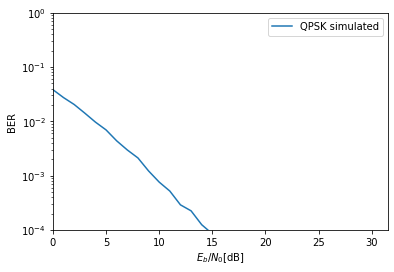

In [ ]:
#実験結果
plt.plot(
    np.loadtxt(path + "/{}_{}_{}{}_{}_{}_{}.csv".format(
        errorMode,
        rateMode,
        M,
        mode,
        Nt,
        Nr,
        DEMUXmode
    ))[0],
    np.loadtxt(path + "/{}_{}_{}{}_{}_{}_{}.csv".format(
        errorMode,
        rateMode,
        M,
        mode,
        Nt,
        Nr,
        DEMUXmode
    ))[1],
    label = "QPSK simulated"
)

plt.yscale('log')

plt.xlabel("$E_b/N_0$[dB]")
plt.ylabel("BER")

plt.xlim(0)
plt.ylim(10 ** (-4), 1)

plt.legend()

plt.savefig(path + "/{}_{}_{}{}_{}_{}_{}.png".format(
        errorMode,
        rateMode,
        M,
        mode,
        Nt,
        Nr,
        DEMUXmode
    ))

plt.show()

####  $Nt = 1, Nr = 4$

パラメータ

|    |    |
| ---- | ---- |
| 送信アンテナ数 | 1 |
| 受信アンテナ数 | 2 |
| 変調方式 | QPSK |
| チャネル　|　レイリーフェージング|
|  試行回数  |  10万回  |
|  $E_b/N_0$  |  0[dB]~30[dB]  |
| 送信電力 | 1 |
|ダイバーシチ|選択合成|

In [ ]:
#誤り基準
errorMode = "BER"

#変調方式
mode = "PSK"

#多値数
M = 2

#試行回数
informationSize = 100000

#EbN0
rateMode = "EbN0"
EbN0_MIN = 0
EbN0_MAX = 30

#定義域(SNR)
N = (EbN0_MAX - EbN0_MIN) + 1
EbN0 = np.linspace(EbN0_MIN, EbN0_MAX, N)

#送信電力
powerOfSignal = 1.0

#送信/受信アンテナ数
Nt, Nr = 1, 4

#ダイバーシチ
MUXmode = ""
DEMUXmode = "SC"

In [ ]:
modulator = Modulator(M = M, mode = mode, powerOfSignal = powerOfSignal)

awgnAdder = AwgnAdder()

demodulator = Demodulator(M = M, mode = mode, powerOfSignal = powerOfSignal)

errorCalculator = ErrorCalculator(M = M, errorMode = errorMode)

In [ ]:
#データを変調
dataOrigin = np.random.randint(low = 0, high = 1 << M, size = [1, informationSize])
symbol = modulator.modulate(dataOrigin)

##### 実行

In [ ]:
BER_EbN0_QPSK = np.zeros(shape = EbN0.shape)

for n in range(N):
  dataDemodulated = np.empty( symbol.shape, dtype = int )
  for i in range(informationSize):
    #進捗確認バー
    if (i * 10) % informationSize == 0:
      print('#' * ( (i * 10) // informationSize ) )

    #シンボルsを通信路Hに通しノイズnをのせる
    channel = KroneckerChannel(Nt = Nt, Nr = Nr, rho = 0)

    symbol_i = np.array([[ symbol[0][i] ]])
    symbolTransported = channel.transport( symbol_i )

    symbolNoized = awgnAdder.addAwgn(
                                      symbolTransported, 
                                      calcVariance(
                                          rate = EbN0[n], rateMode = rateMode,
                                          M = M, P_S = powerOfSignal)
                                    )
    
    #ウェイトをDEMUXでかけて，復調
    demux = DEMUX(Nt = Nt, Nr = Nr, H = channel.channelMatrix, DEMUXmode = DEMUXmode)
    symbolDemultiplexed = demux.demultiplex(symbolNoized)

    dataDemodulated_ = demodulator.demodulate(symbolDemultiplexed)
    dataDemodulated[0][i] = dataDemodulated_

  #元のデータと復調データを照らし合わせてBER計算
  ber = errorCalculator.calcError(dataOrigin, dataDemodulated)

  '''debug start'''
  '''
  print("dataOrigin {}".format(dataOrigin))
  print("symbol {}".format(symbol))
  print("H {}".format(channel.channelMatrix) )
  print("symbolNoized {}".format(symbolNoized) )
  print("symbolDemultiplexed ".format(symbolDemultiplexed))
  print("dataDemodulated {}".format( dataDemodulated) )
  '''
  '''debug end'''

  print("EbN0: {} BER: {}".format( EbN0[n], ber) )
  BER_EbN0_QPSK[n] = ber

#BER_EbN0_QPSK_1_2_SC
np.savetxt(
    path + "/{}_{}_{}{}_{}_{}_{}.csv".format(
        errorMode,
        rateMode,
        M,
        mode,
        Nt,
        Nr,
        DEMUXmode
    ), 
    np.stack([
      EbN0,
      BER_EbN0_QPSK
]))


#
##
###
####
#####
######
#######
########
#########
EbN0: 0.0 BER: 0.00235

#
##
###
####
#####
######
#######
########
#########
EbN0: 1.0 BER: 0.00127

#
##
###
####
#####
######
#######
########
#########
EbN0: 2.0 BER: 0.00056

#
##
###
####
#####
######
#######
########
#########
EbN0: 3.0 BER: 0.0003

#
##
###
####
#####
######
#######
########
#########
EbN0: 4.0 BER: 0.00015

#
##
###
####
#####
######
#######
########
#########
EbN0: 5.0 BER: 8e-05

#
##
###
####
#####
######
#######
########
#########
EbN0: 6.0 BER: 5e-05

#
##
###
####
#####
######
#######
########
#########
EbN0: 7.0 BER: 2e-05

#
##
###
####
#####
######
#######
########
#########
EbN0: 8.0 BER: 1e-05

#
##
###
####
#####
######
#######
########
#########
EbN0: 9.0 BER: 5e-06

#
##
###
####
#####
######
#######
########
#########
EbN0: 10.0 BER: 0.0

#
##
###
####
#####
######
#######
########
#########
EbN0: 11.0 BER: 0.0

#
##
###
####
#####
######
#######
########
#########
EbN0: 12.0 BER: 0.0

#
##


##### 実行結果

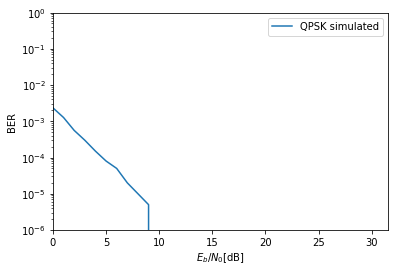

In [ ]:
#実験結果
plt.plot(
    np.loadtxt(path + "/{}_{}_{}{}_{}_{}_{}.csv".format(
        errorMode,
        rateMode,
        M,
        mode,
        Nt,
        Nr,
        DEMUXmode
    ))[0],
    np.loadtxt(path + "/{}_{}_{}{}_{}_{}_{}.csv".format(
        errorMode,
        rateMode,
        M,
        mode,
        Nt,
        Nr,
        DEMUXmode
    ))[1],
    label = "QPSK simulated"
)

plt.yscale('log')

plt.xlabel("$E_b/N_0$[dB]")
plt.ylabel("BER")

plt.xlim(0)
plt.ylim(10 ** (-6), 1)

plt.legend()

plt.savefig(path + "/{}_{}_{}{}_{}_{}_{}.png".format(
        errorMode,
        rateMode,
        M,
        mode,
        Nt,
        Nr,
        DEMUXmode
    ))

plt.show()

### MRC

####  $Nt = 1, Nr = 2$

パラメータ

|    |    |
| ---- | ---- |
| 送信アンテナ数 | 1 |
| 受信アンテナ数 | 2 |
| 変調方式 | QPSK |
| チャネル　|　レイリーフェージング|
|  試行回数  |  10万回  |
|  $E_b/N_0$  |  0[dB]~30[dB]  |
| 送信電力 | 1 |
|ダイバーシチ|最大比合成|

In [ ]:
#誤り基準
errorMode = "BER"

#変調方式
mode = "PSK"

#多値数
M = 2

#試行回数
informationSize = 100000

#EbN0
rateMode = "EbN0"
EbN0_MIN = 0
EbN0_MAX = 30

#定義域(SNR)
N = (EbN0_MAX - EbN0_MIN) + 1
EbN0 = np.linspace(EbN0_MIN, EbN0_MAX, N)

#送信電力
powerOfSignal = 1.0

#送信/受信アンテナ数
Nt, Nr = 1, 2

#ダイバーシチ
MUXmode = ""
DEMUXmode = "MRC"

In [ ]:
modulator = Modulator(M = M, mode = mode, powerOfSignal = powerOfSignal)

awgnAdder = AwgnAdder()

demodulator = Demodulator(M = M, mode = mode, powerOfSignal = powerOfSignal)

errorCalculator = ErrorCalculator(M = M, errorMode = errorMode)

In [ ]:
#データを変調
dataOrigin = np.random.randint(low = 0, high = 1 << M, size = [1, informationSize])
symbol = modulator.modulate(dataOrigin)

##### 実行

In [ ]:
BER_EbN0_QPSK = np.zeros(shape = EbN0.shape)

for n in range(N):
  dataDemodulated = np.empty( symbol.shape, dtype = int )
  for i in range(informationSize):
    #進捗確認バー
    if (i * 10) % informationSize == 0:
      print('#' * ( (i * 10) // informationSize ) )

    #シンボルsを通信路Hに通しノイズnをのせる
    channel = KroneckerChannel(Nt = Nt, Nr = Nr, rho = 0)

    symbol_i = np.array([[ symbol[0][i] ]])
    symbolTransported = channel.transport( symbol_i )

    symbolNoized = awgnAdder.addAwgn(
                                      symbolTransported, 
                                      calcVariance(
                                          rate = EbN0[n], rateMode = rateMode,
                                          M = M, P_S = powerOfSignal)
                                    )
    
    #ウェイトをDEMUXでかけて，復調
    demux = DEMUX(Nt = Nt, Nr = Nr, H = channel.channelMatrix, DEMUXmode = DEMUXmode)
    symbolDemultiplexed = demux.demultiplex(symbolNoized)

    dataDemodulated_ = demodulator.demodulate(symbolDemultiplexed)
    dataDemodulated[0][i] = dataDemodulated_

  #元のデータと復調データを照らし合わせてBER計算
  ber = errorCalculator.calcError(dataOrigin, dataDemodulated)

  '''debug start'''
  '''
  print("dataOrigin {}".format(dataOrigin))
  print("symbol {}".format(symbol))
  print("H {}".format(channel.channelMatrix) )
  print("symbolNoized {}".format(symbolNoized) )
  print("symbolDemultiplexed ".format(symbolDemultiplexed))
  print("dataDemodulated {}".format( dataDemodulated) )
  '''
  '''debug end'''

  print("EbN0: {} BER: {}".format( EbN0[n], ber) )
  BER_EbN0_QPSK[n] = ber

#BER_EbN0_QPSK_1_4_MRC
np.savetxt(
    path + "/{}_{}_{}{}_{}_{}_{}.csv".format(
        errorMode,
        rateMode,
        M,
        mode,
        Nt,
        Nr,
        DEMUXmode
    ), 
    np.stack([
      EbN0,
      BER_EbN0_QPSK
]))


#
##
###
####
#####
######
#######
########
#########
EbN0: 0.0 BER: 0.023615

#
##
###
####
#####
######
#######
########
#########
EbN0: 1.0 BER: 0.017045

#
##
###
####
#####
######
#######
########
#########
EbN0: 2.0 BER: 0.0118

#
##
###
####
#####
######
#######
########
#########
EbN0: 3.0 BER: 0.00814

#
##
###
####
#####
######
#######
########
#########
EbN0: 4.0 BER: 0.00539

#
##
###
####
#####
######
#######
########
#########
EbN0: 5.0 BER: 0.00367

#
##
###
####
#####
######
#######
########
#########
EbN0: 6.0 BER: 0.00252

#
##
###
####
#####
######
#######
########
#########
EbN0: 7.0 BER: 0.00175

#
##
###
####
#####
######
#######
########
#########
EbN0: 8.0 BER: 0.00118

#
##
###
####
#####
######
#######
########
#########
EbN0: 9.0 BER: 0.00073

#
##
###
####
#####
######
#######
########
#########
EbN0: 10.0 BER: 0.00048

#
##
###
####
#####
######
#######
########
#########
EbN0: 11.0 BER: 0.000255

#
##
###
####
#####
######
#######
########
#########
EbN0:

##### 実行結果

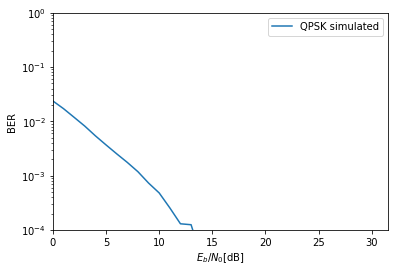

In [ ]:
#実験結果
plt.plot(
    np.loadtxt(path + "/{}_{}_{}{}_{}_{}_{}.csv".format(
        errorMode,
        rateMode,
        M,
        mode,
        Nt,
        Nr,
        DEMUXmode
    ))[0],
    np.loadtxt(path + "/{}_{}_{}{}_{}_{}_{}.csv".format(
        errorMode,
        rateMode,
        M,
        mode,
        Nt,
        Nr,
        DEMUXmode
    ))[1],
    label = "QPSK simulated"
)

plt.yscale('log')

plt.xlabel("$E_b/N_0$[dB]")
plt.ylabel("BER")

plt.xlim(0)
plt.ylim(10 ** (-4), 1)

plt.legend()

plt.savefig(path + "/{}_{}_{}{}_{}_{}_{}.png".format(
        errorMode,
        rateMode,
        M,
        mode,
        Nt,
        Nr,
        DEMUXmode
    ))

plt.show()

####  $Nt = 1, Nr = 4$

パラメータ

|    |    |
| ---- | ---- |
| 送信アンテナ数 | 1 |
| 受信アンテナ数 | 2 |
| 変調方式 | QPSK |
| チャネル　|　レイリーフェージング|
|  試行回数  |  10万回  |
|  $E_b/N_0$  |  0[dB]~30[dB]  |
| 送信電力 | 1 |
|ダイバーシチ|最大比合成|

In [ ]:
#誤り基準
errorMode = "BER"

#変調方式
mode = "PSK"

#多値数
M = 2

#試行回数
informationSize = 100000

#EbN0
rateMode = "EbN0"
EbN0_MIN = 0
EbN0_MAX = 30

#定義域(SNR)
N = (EbN0_MAX - EbN0_MIN) + 1
EbN0 = np.linspace(EbN0_MIN, EbN0_MAX, N)

#送信電力
powerOfSignal = 1.0

#送信/受信アンテナ数
Nt, Nr = 1, 4

#ダイバーシチ
MUXmode = ""
DEMUXmode = "MRC"

In [ ]:
modulator = Modulator(M = M, mode = mode, powerOfSignal = powerOfSignal)

awgnAdder = AwgnAdder()

demodulator = Demodulator(M = M, mode = mode, powerOfSignal = powerOfSignal)

errorCalculator = ErrorCalculator(M = M, errorMode = errorMode)

In [ ]:
#データを変調
dataOrigin = np.random.randint(low = 0, high = 1 << M, size = [1, informationSize])
symbol = modulator.modulate(dataOrigin)

##### 実行

In [ ]:
BER_EbN0_QPSK = np.zeros(shape = EbN0.shape)

for n in range(N):
  dataDemodulated = np.empty( symbol.shape, dtype = int )
  for i in range(informationSize):
    #進捗確認バー
    if (i * 10) % informationSize == 0:
      print('#' * ( (i * 10) // informationSize ) )

    #シンボルsを通信路Hに通しノイズnをのせる
    channel = KroneckerChannel(Nt = Nt, Nr = Nr, rho = 0)

    symbol_i = np.array([[ symbol[0][i] ]])
    symbolTransported = channel.transport( symbol_i )

    symbolNoized = awgnAdder.addAwgn(
                                      symbolTransported, 
                                      calcVariance(
                                          rate = EbN0[n], rateMode = rateMode,
                                          M = M, P_S = powerOfSignal)
                                    )
    
    #ウェイトをDEMUXでかけて，復調
    demux = DEMUX(Nt = Nt, Nr = Nr, H = channel.channelMatrix, DEMUXmode = DEMUXmode)
    symbolDemultiplexed = demux.demultiplex(symbolNoized)

    dataDemodulated_ = demodulator.demodulate(symbolDemultiplexed)
    dataDemodulated[0][i] = dataDemodulated_

  #元のデータと復調データを照らし合わせてBER計算
  ber = errorCalculator.calcError(dataOrigin, dataDemodulated)

  '''debug start'''
  '''
  print("dataOrigin {}".format(dataOrigin))
  print("symbol {}".format(symbol))
  print("H {}".format(channel.channelMatrix) )
  print("symbolNoized {}".format(symbolNoized) )
  print("symbolDemultiplexed ".format(symbolDemultiplexed))
  print("dataDemodulated {}".format( dataDemodulated) )
  '''
  '''debug end'''

  print("EbN0: {} BER: {}".format( EbN0[n], ber) )
  BER_EbN0_QPSK[n] = ber

#BER_EbN0_QPSK_1_4_MRC
np.savetxt(
    path + "/{}_{}_{}{}_{}_{}_{}.csv".format(
        errorMode,
        rateMode,
        M,
        mode,
        Nt,
        Nr,
        DEMUXmode
    ), 
    np.stack([
      EbN0,
      BER_EbN0_QPSK
]))


#
##
###
####
#####
######
#######
########
#########
EbN0: 0.0 BER: 0.00025

#
##
###
####
#####
######
#######
########
#########
EbN0: 1.0 BER: 0.000115

#
##
###
####
#####
######
#######
########
#########
EbN0: 2.0 BER: 6.5e-05

#
##
###
####
#####
######
#######
########
#########
EbN0: 3.0 BER: 1.5e-05

#
##
###
####
#####
######
#######
########
#########
EbN0: 4.0 BER: 0.0

#
##
###
####
#####
######
#######
########
#########
EbN0: 5.0 BER: 0.0

#
##
###
####
#####
######
#######
########
#########
EbN0: 6.0 BER: 0.0

#
##
###
####
#####
######
#######
########
#########
EbN0: 7.0 BER: 5e-06

#
##
###
####
#####
######
#######
########
#########
EbN0: 8.0 BER: 0.0

#
##
###
####
#####
######
#######
########
#########
EbN0: 9.0 BER: 0.0

#
##
###
####
#####
######
#######
########
#########
EbN0: 10.0 BER: 5e-06

#
##
###
####
#####
######
#######
########
#########
EbN0: 11.0 BER: 0.0

#
##
###
####
#####
######
#######
########
#########
EbN0: 12.0 BER: 0.0

#
##
###
####

##### 実行結果

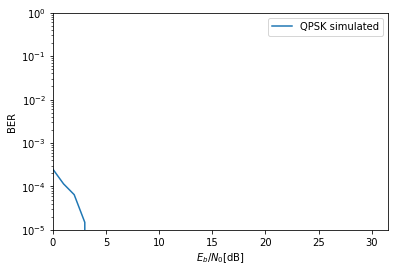

In [ ]:
#実験結果
plt.plot(
    np.loadtxt(path + "/{}_{}_{}{}_{}_{}_{}.csv".format(
        errorMode,
        rateMode,
        M,
        mode,
        Nt,
        Nr,
        DEMUXmode
    ))[0],
    np.loadtxt(path + "/{}_{}_{}{}_{}_{}_{}.csv".format(
        errorMode,
        rateMode,
        M,
        mode,
        Nt,
        Nr,
        DEMUXmode
    ))[1],
    label = "QPSK simulated"
)

plt.yscale('log')

plt.xlabel("$E_b/N_0$[dB]")
plt.ylabel("BER")

plt.xlim(0)
plt.ylim(10 ** (-5), 1)

plt.legend()

plt.savefig(path + "/{}_{}_{}{}_{}_{}_{}.png".format(
        errorMode,
        rateMode,
        M,
        mode,
        Nt,
        Nr,
        DEMUXmode
    ))

plt.show()

## まとめ


### SC

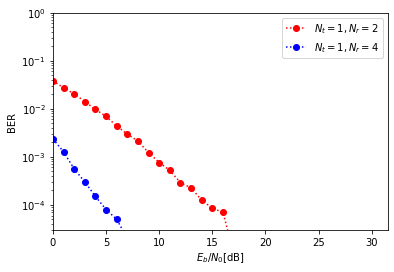

In [ ]:
#1-2
plt.plot(
    np.loadtxt(path + "/BER_EbN0_2PSK_1_2_SC.csv")[0],
    np.loadtxt(path + "/BER_EbN0_2PSK_1_2_SC.csv")[1],
    "ro:",
    label = "$N_t = {}, N_r = {}$".format(1, 2)
)

#1-4
plt.plot(
    np.loadtxt(path + "/BER_EbN0_2PSK_1_4_SC.csv")[0],
    np.loadtxt(path + "/BER_EbN0_2PSK_1_4_SC.csv")[1],
    "bo:",
    label = "$N_t = {}, N_r = {}$".format(1, 4)
)

plt.yscale('log')

plt.xlabel("$E_b/N_0$[dB]")
plt.ylabel("BER")

plt.xlim(0)
plt.ylim(10 ** (-5) * 3, 1)

plt.legend()


plt.savefig(path + "/BER_EbN0_2PSK_SC.png")


plt.show()

### MRC

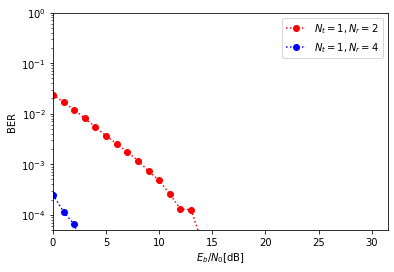

In [ ]:
#1-2
plt.plot(
    np.loadtxt(path + "/BER_EbN0_2PSK_1_2_MRC.csv")[0],
    np.loadtxt(path + "/BER_EbN0_2PSK_1_2_MRC.csv")[1],
    "ro:",
    label = "$N_t = {}, N_r = {}$".format(1, 2)
)

#1-4
plt.plot(
    np.loadtxt(path + "/BER_EbN0_2PSK_1_4_MRC.csv")[0],
    np.loadtxt(path + "/BER_EbN0_2PSK_1_4_MRC.csv")[1],
    "bo:",
    label = "$N_t = {}, N_r = {}$".format(1, 4)
)

plt.yscale('log')

plt.xlabel("$E_b/N_0$[dB]")
plt.ylabel("BER")

plt.xlim(0)
plt.ylim(10 ** (-5) * 5, 1)

plt.legend()


plt.savefig(path + "/BER_EbN0_2PSK_MRC.png")


plt.show()